In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from utils import set_plots_size_params, plot_overview 

In [2]:
freqs = pd.read_csv('new_pipe/all_freqs.csv')

In [3]:
freqs

,ref_pos,read_base,base_count,ref_base,coverage,frequency,base_rank,probability,passage,km
0,1.0,-,0.0,G,1534.0,0.0,4.0,-0.000154,3,1
1,1.0,A,0.0,G,1534.0,0.0,4.0,-0.000154,3,1
2,1.0,C,0.0,G,1534.0,0.0,4.0,-0.000154,3,1
3,1.0,G,1534.0,G,1534.0,1.0,0.0,1.000000,3,1
4,1.0,T,0.0,G,1534.0,0.0,4.0,-0.000154,3,1
...,...,...,...,...,...,...,...,...,...,...
170610,3569.0,-,0.0,A,1268.0,0.0,4.0,-0.000127,10,3
170611,3569.0,A,1268.0,A,1268.0,1.0,0.0,1.000000,10,3
170612,3569.0,C,0.0,A,1268.0,0.0,4.0,-0.000127,10,3
170613,3569.0,G,0.0,A,1268.0,0.0,4.0,-0.000127,10,3


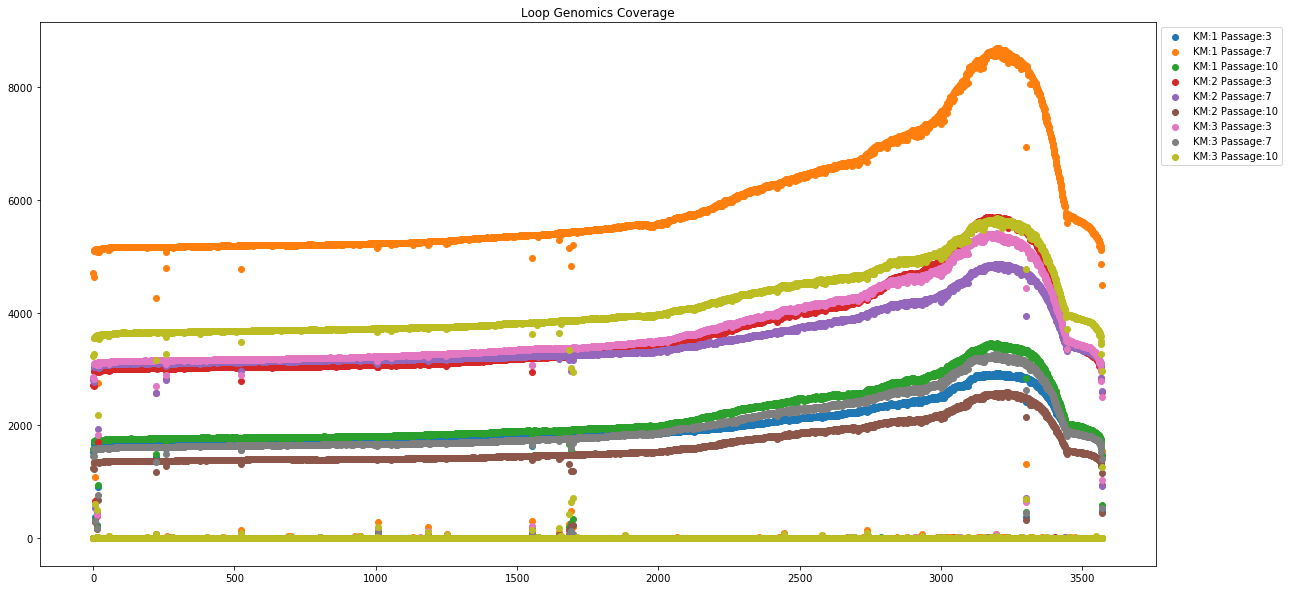

In [4]:
plt.figure(figsize=(20, 10))
for km in freqs.km.unique():
    for pas in freqs.passage.unique():
        df = freqs[freqs.km==km]
        df = df[df.passage==pas]
        plt.scatter(df.ref_pos, df.base_count, label=f"KM:{km} Passage:{pas}")
plt.legend(bbox_to_anchor=(1, 1))
plt.title("Loop Genomics Coverage")
plt.savefig('loop_coverage_end.png')

In [5]:
def get_mutation_data(freqs):
    mutation_data = freqs[(
        ((freqs.frequency>0.001) & (freqs.frequency<0.5)) | (freqs.ref_pos!=round(freqs.ref_pos))) &
        (freqs.coverage>50) &
        (freqs.ref_pos>=23) & (freqs.ref_pos<=3549)].copy()
    mutation_data = mutation_data.sort_values(by=['passage'])
    coverages = freqs[['coverage', 'ref_pos', 'passage', 'km']].sort_values(
        by=['km', 'passage', 'ref_pos']).set_index(['km', 'passage', 'ref_pos'])
    mutation_data['coverage'] = mutation_data.apply(
        lambda row: coverages.loc[(row.km, row.passage, round(row.ref_pos))].coverage[0], axis=1)
    mutation_data.loc[mutation_data.ref_base=="-", "frequency"] = mutation_data.loc[mutation_data.ref_base=="-", "coverage"] * \
                                                        mutation_data.loc[mutation_data.ref_base=="-", "frequency"] / \
                                                        mutation_data.loc[mutation_data.ref_base=="-", "coverage"]
    return mutation_data[(mutation_data.frequency>0.001) & (mutation_data.frequency<0.5)]


def mutation_time_series(df, ax, colors_dict, going=None):
    x = df.passage
    y = df.frequency
    if going=='up':
        if y.iloc[0] >= y.iloc[-1]*0.7:
            return
    if going=='down':
        if y.iloc[0] <= y.iloc[-1]*0.7:
            return
    label = f"{df.ref_pos.iloc[0]}{df.read_base.iloc[0]}"
    if label in colors_dict.keys():
        color = colors_dict[label]
        alpha = 1
    else:
        color = 'black'
        label = None
        alpha = 0.1
    ax.plot(df.passage, df.frequency, color=color, label=label, alpha=alpha)
    # ax.text(x.iloc[-1], y.iloc[-1], label)  # <- text next to plot!
    return ax


def muts_overview(data, ax):
    plt.figure(figsize=(20, 10))
    base_color = {'A': 'red',
                  'G': 'blue',
                  'C': 'orange',
                  'T': 'green',
                  '-': 'black'}
    for letter in data.read_base.unique():
        letter_df = data[data.read_base==letter]
        for phase in letter_df.passage.unique():
            phase_df = letter_df[letter_df.passage==phase]
            y = phase_df[f'frequency']
            ax.scatter(phase_df.ref_pos, y, label=f"{letter}{phase}", color=base_color[letter], alpha=1.1-(int(phase)/10))
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylim([-0.02,0.53])
    ax.set_xlabel('Postion')
    ax.set_ylabel('Frequency')
    return ax


In [6]:
def plot_overview(freqs):
    fig, axes = plt.subplots(figsize=(60, 30), ncols=3, nrows=3)
    plt.suptitle("MS2 Time Series AccuNGS MOI 0.1 with coverage>50", fontsize=18)
    plt.subplots_adjust(wspace=0.3, hspace=0.25)
    print("Getting Mutation Data...")
    mutation_data = get_mutation_data(freqs)
    top_mutations = mutation_data.groupby(['ref_pos','read_base']).frequency.max().sort_values(ascending=False).head(20).index
    top_mutations = [f'{pos}{base}' for (pos, base) in top_mutations]
    color_list = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45',
                  '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
                  '#000075', '#000000']
    color_dict = {top_mutations[i]: color_list[i] for i in range(len(top_mutations))}
    print("Creating graphs!")
    for i in range(3):
        km_muts = mutation_data[mutation_data.km==i+1]
        axes[0][i] = muts_overview(km_muts[km_muts.frequency>0.01], axes[0][i])
        axes[0][i].set_title(f"Mutations Overview Sample {i+1}")
        km_muts.groupby(['ref_pos', 'read_base']).apply(
            lambda df: mutation_time_series(df, axes[1][i], color_dict, going='up'))
        axes[1][i].set_ylim([-0.01,0.5])
        axes[1][i].legend(bbox_to_anchor=(1, 0.7))
        axes[1][i].set_title(f"Mutations Increasing in Frequency in Sample {i+1}")
        axes[1][i].set_xlabel('Passage')
        axes[1][i].set_ylabel('Frequency')
        km_muts.groupby(['ref_pos', 'read_base']).apply(
            lambda df: mutation_time_series(df, axes[2][i], color_dict, going='down'))
        axes[2][i].set_ylim([-0.01,0.4])
        axes[2][i].set_xlabel('Passage')
        axes[2][i].set_ylabel('Frequency')
        axes[2][i].set_title(f"Mutations Decreasing in Frequency in Sample {i+1}")
        axes[2][i].legend(bbox_to_anchor=(1, 1))
    return fig, axes

Getting Mutation Data...
Creating graphs!


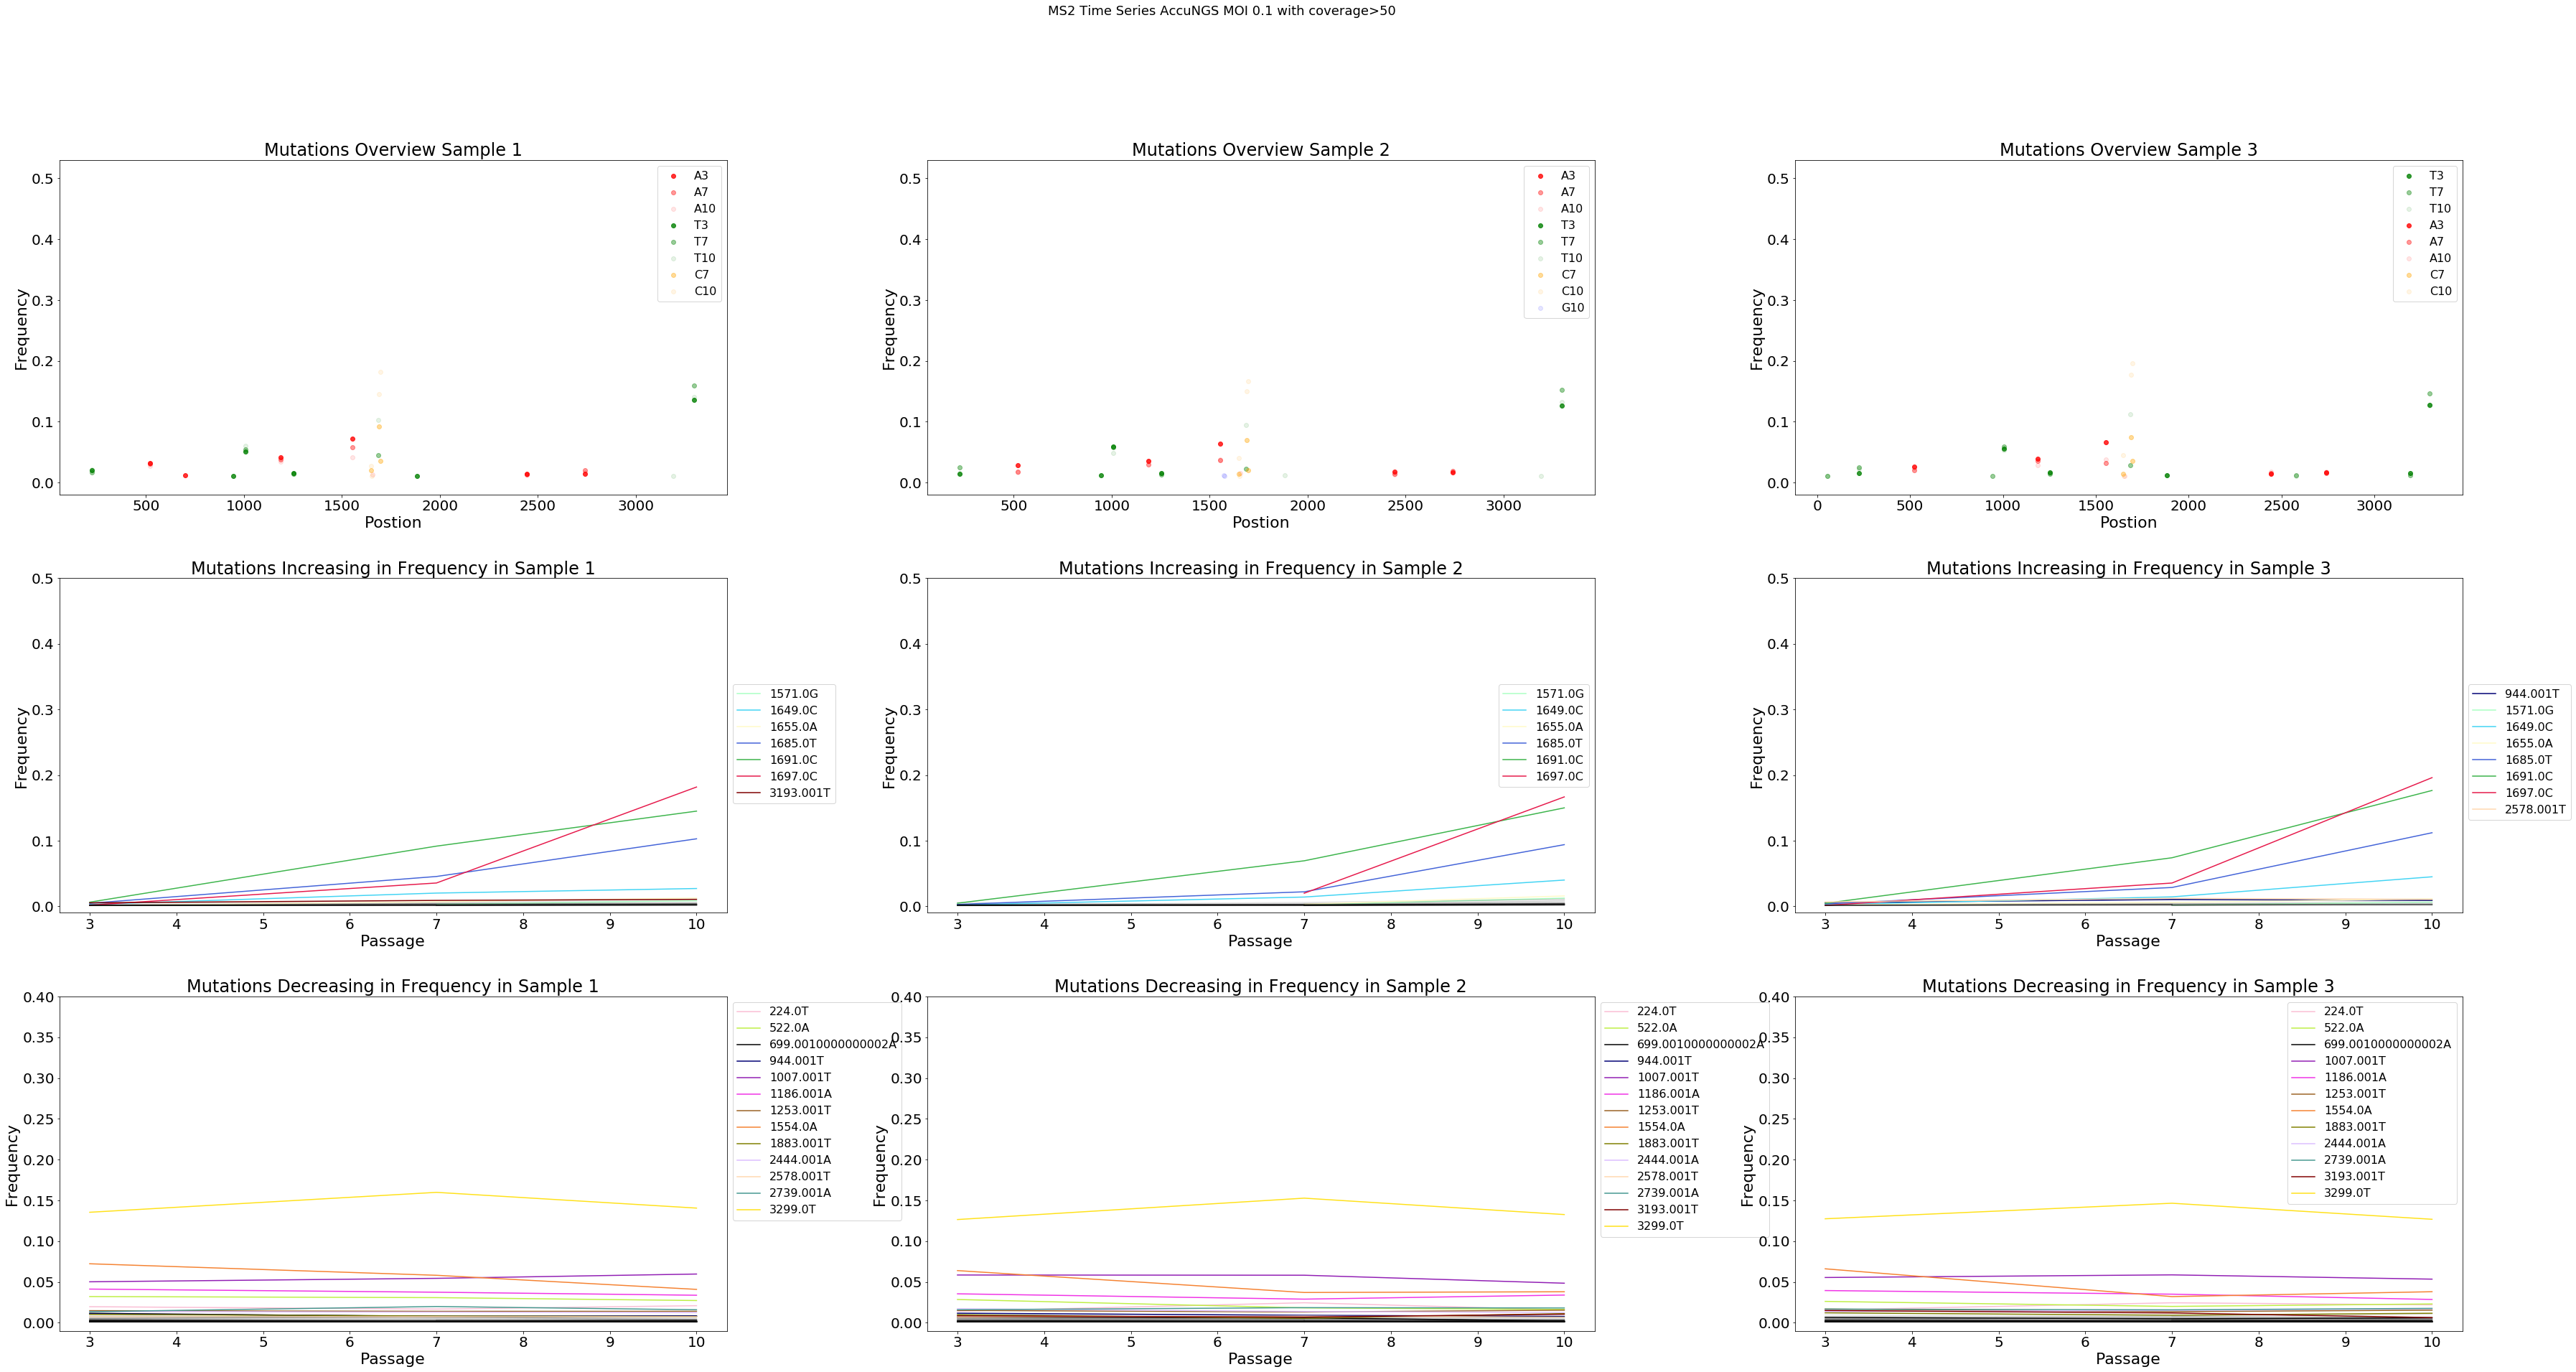

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [7]:
set_plots_size_params(20)
fig, axes = plot_overview(freqs)


In [8]:
adaptive_mutations = [(1697.0,'C'), (1691.0, 'C'), (1685.0, 'T'), (1649.0,'C')]